In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import dense_diff_pool
from torch import Tensor
from typing import Tuple

from torch_geometric.utils import to_networkx, negative_sampling
import networkx as nx

In [4]:
import utils.torchUtils as gnn
from utils.torchUtils.cpp_geometric import layers

In [5]:
dout='knn'

In [6]:
# gnn.config.set_gpu(False)

In [7]:
from torch_scatter import scatter_max
from torch_geometric.data import Batch


# class Sampled(gnn.BaseTransform):
#     def __call__(self, data : Data) -> Data:
#         num_nodes = data.num_nodes 
#         centers = [ sample_center(data, i) for i in range(num_nodes) ]
#         batch = Batch.from_data_list(
#             [
#                 gnn.mask_graph(data, center)
#                 for center in centers
#             ]
#         )
#         return batch

In [8]:
import utils.torchUtils as gnn 

# min_edge = gnn.min_edge_neighbor(n_neighbor=2, function=lambda f:f**2)
min_edge = gnn.min_edge_neighbor(n_neighbor=4, undirected=True)
transform = None
transform = gnn.Transform(min_edge)
template = gnn.Dataset('../data/template',make_template=True, transform=transform)

def load_training(fn='../data/MX_1200_MY_500-training', template=None):
    transform = template.transform + gnn.RandomSample()
    dataset = gnn.Dataset(fn,transform=transform)[:9000]
    training, validation = gnn.train_test_split(dataset, 0.2)

    batch_size = 100
    trainloader = DataLoader(training, batch_size=batch_size, num_workers=gnn.config.ncpu)
    validloader = DataLoader(validation, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return trainloader, validloader

def load_testing(fn='../data/MX_1200_MY_500-testing', template=None):
    transform = template.transform + gnn.RandomSample()
    sample = gnn.Dataset(fn, transform=transform)[:1000]
    batch_size = 100
    testloader = DataLoader(sample, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return testloader

trainloader, validloader  = load_training(template=template)
testloader = load_testing(template=template)

In [9]:
model = gnn.modelMap['golden_knn'](dataset=template, loss='auroc_loss')

# model = gnn.modelMap['golden_knn'].load_from_checkpoint(model_paths[0]).to(device=gnn.config.device)

In [10]:
for batch in trainloader: break

In [11]:
_, edge_o = model(batch)

In [12]:
from pytorch_lightning import Trainer

trainer = Trainer(max_epochs=10, gpus=1*gnn.config.useGPU)
trainer.fit(model, trainloader, validloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
2022-05-02 12:45:10.884723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 12:45:10.884771: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

   | Name         | Type            | Params
--------------------------------------------------
0  | embed_1      | GCNLinear       | 768   
1  | conv_1       | GCNConvMask     | 12.4 K
2  | norm_1       | GCNBatchNorm    | 256   
3  | relu_1       | GCNRelu         | 0     
4  | embed_2      | GCNLinear       | 16.6 K
5  | conv_2       | GCNConvMask     | 49.3 K
6  | norm_2       | GCNBatchNorm    | 512   
7  | relu_2       | GCNRelu         | 0     
8  | node_readout | Sequential      | 15.6 K

Epoch 9: 100%|██████████| 90/90 [00:10<00:00,  8.21it/s, loss=4.97, v_num=105]


In [13]:
test = trainer.test(model, testloader)

Testing:  80%|████████  | 8/10 [00:00<00:00, 12.81it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'edge_acc/test': 0.7785916328430176,
 'edge_auroc/test': 0.9048237800598145,
 'loss/test': 4.992600440979004,
 'node_acc/test': 0.6169172525405884,
 'node_auroc/test': 0.4419599175453186,
 'top_acc/test': 0.6952334642410278}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 10/10 [00:01<00:00,  9.31it/s]


In [14]:
def draw_predict(model, data, edge_mask=None):
    if edge_mask is not None:
        data = gnn.mask_graph(data, edge_mask)
    _, edge_o = model.predict(data)

    edges = torch.arange(edge_o.shape[0])
    argorder = torch.argsort(-edge_o)
    order = torch.argmax(1*(edges[:,None] == argorder),axis=-1)

    gnn.draw_data(data, width=edge_o, edge_labels=order, undirected=0)


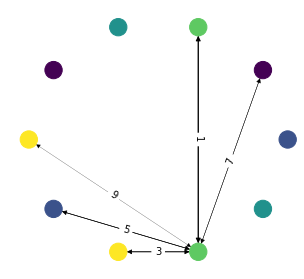

In [29]:
data = next( data for data in testloader.dataset if data.y.sum() == 8 and data.num_nodes == 10 )
draw_predict(model, data)